In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.core.debugger import prompt
from numpy import dtype

In [2]:
data_path = '../data'
train = pd.read_csv(f'{data_path}/chillies_gpt_eval_train.csv')
test = pd.read_csv(f'{data_path}/chillies_gpt_eval_test.csv')

In [3]:
def process_dataset(dataset):
    questions = []
    essays = []
    bands = []
    
    for prompt, essay, band in zip(dataset['prompt'], dataset['essay'], dataset['band']):
        processed_question = str(prompt.strip())
        processed_essay = str(essay.strip())
        while band[0] == '<':
            band = band[1:]
        processed_band = float(band.strip())
        
        if len(processed_question) < 10 or len(processed_essay) < 10:
            print('bad row: ', processed_question, processed_essay)
            continue
        
        questions.append(processed_question)
        essays.append(processed_essay)
        bands.append(processed_band)
        
    return pd.DataFrame(data={'question': questions, 'essay': essays, 'band': bands})

In [4]:
processed_train = process_dataset(train)
processed_test = process_dataset(test)

bad row:  Some people believe that studying at university or college is the best route to a  successful career, while others believe that it is better to get a job straight after school.  Discuss both views and give your opinion. #NAME?


<Axes: >

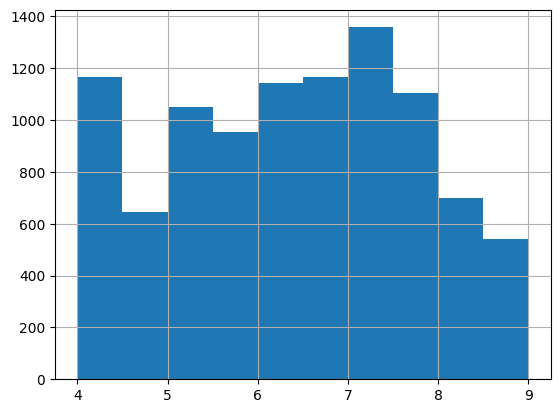

In [5]:
processed_train['band'].hist()

<Axes: >

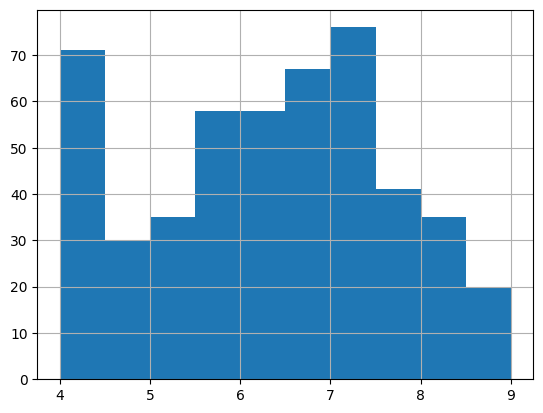

In [6]:
processed_test['band'].hist()

In [10]:
# https://huggingface.co/jinaai/jina-embeddings-v3 
# https://huggingface.co/hs-hf/jina-embeddings-v3-distilled

from model2vec import StaticModel

# Load a pretrained Model2Vec model
model = StaticModel.from_pretrained("hs-hf/jina-embeddings-v3-distilled")

# Compute text embeddings
# embeddings = model.encode(["Example sentence"])


In [17]:
embeddings = model.encode(["Example sentence hi"])

In [18]:
embeddings.shape

(1, 512)

In [40]:
def compute_embeddings(processed_df):
    X = []
    Y = []
    for q, a, b in tqdm(zip(processed_df['question'], processed_df['essay'], processed_df['band'])):
        qv = model.encode([q]).squeeze()
        av = model.encode([a]).squeeze()
        X.append(np.concatenate([qv, av]))
        Y.append(b)
    return np.array(X), np.array(Y)

In [41]:
X_train, Y_train = compute_embeddings(processed_train)

9832it [00:06, 1620.69it/s]


In [42]:
X_test, Y_test = compute_embeddings(processed_test)

491it [00:00, 1462.29it/s]


In [44]:
import torch
from torch import nn

In [153]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.float()
        
        self.fc1 = nn.Linear(X_train.shape[1], 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [154]:
from torch.utils.data import Dataset, DataLoader

class BandDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], np.array([self.y[idx]], dtype=np.float32)

In [155]:
band_model = NeuralNetwork()

In [156]:
print(band_model)

NeuralNetwork(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [157]:
loss_fn = nn.MSELoss(reduction='mean')

In [158]:
optimizer = torch.optim.Adam(band_model.parameters(), lr=0.001)

In [159]:
train_dataset = DataLoader(BandDataset(X_train, Y_train), batch_size=64, shuffle=True)
test_dataset = DataLoader(BandDataset(X_test, Y_test), batch_size=64, shuffle=True)


In [164]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [165]:
for epoch in tqdm(range(1)):
    train_loop(train_dataset, band_model, loss_fn, optimizer)

100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

loss: 0.197049  [   64/ 9832]
loss: 0.323903  [  704/ 9832]
loss: 0.267660  [ 1344/ 9832]
loss: 0.478483  [ 1984/ 9832]
loss: 0.202596  [ 2624/ 9832]
loss: 0.360074  [ 3264/ 9832]
loss: 0.247825  [ 3904/ 9832]
loss: 0.322454  [ 4544/ 9832]
loss: 0.151781  [ 5184/ 9832]
loss: 0.211346  [ 5824/ 9832]
loss: 0.268217  [ 6464/ 9832]
loss: 0.318623  [ 7104/ 9832]
loss: 0.290590  [ 7744/ 9832]
loss: 0.351009  [ 8384/ 9832]
loss: 0.322333  [ 9024/ 9832]
loss: 0.272907  [ 9664/ 9832]


In [166]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [167]:
test_loop(test_dataset, band_model, loss_fn)

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.291748 

